# Boosting Your Data Science Workflow with Dask: A Comprehensive Guide

### Introduction

When Wes McKinney started writing Pandas, he had a rule of thumb: for Pandas to work optimally, the machine's RAM size must be 5-10 times larger than the dataset in question. This rule was easy to follow around 2010, but now it is 2023.

In 2020, real-world datasets had already grown to sizes that could easily crash common everyday laptops and machines. Anticipating this problem well in advance, a solution was released in 2015.

Dask is an open-source library developed by the creators of Anaconda to tackle the challenges of scalable and efficient computing on large datasets that exceed the memory capacity of a single machine.

This tutorial provides a comprehensive introduction to Dask and its crucial features, including interfaces for DataFrames, Arrays, and Bags (yes, you read it right).

### Setting Up Dask

Like any other library, Dask can be installed in three ways: conda, pip, and from source.

Since this is an introductory article on Dask, we won't cover the last installation method, as it is for maintainers.

If you use Anaconda, Dask is included in your default installation (which is a mark of how popular the library is). If you wish to reinstall or upgrade it, you can use the `install` command:

```python
conda install dask
```

The PIP alternative of the above is the following:

```
pip install "dask[complete]"
```

Adding the `[complete]` extension also installs the required dependencies of Dask, eliminating the need to install NumPy, Pandas, and Tornado manually.

You can check if the installation was successful by looking at the library version:

```python
import dask

dask.__version__
```
Output:

```
'2023.5.0'
```

Most of your time spent working with Dask will be focused on three interfaces: Dask DataFrames, Arrays, and Bags. Let's import them along with numpy and pandas to use for the rest of the article:

In [1]:
import dask.array as da
import dask.bag as db
import dask.dataframe as dd
import numpy as np
import pandas as pd

### Basic Concepts of Dask

On a high-level, you can think of Dask as a wrapper that extends the capabilities of traditional tools like Pandas, NumPy, and Spark to handle larger-than-memory datasets.

When faced with large objects like larger-than-memory arrays (vectors) or matrices (dataframes), Dask breaks them up into chunks, also called partitions.

For example, consider the array of 12 random numbers in both NumPy and Dask:

In [2]:
narr = np.random.rand(12)

narr

array([0.9261154 , 0.87774082, 0.87078873, 0.22309476, 0.24575174,
       0.04182393, 0.31476305, 0.04599283, 0.62354124, 0.97597454,
       0.23923457, 0.81201211])

In [3]:
darr = da.from_array(narr, chunks=3)

darr

dask.array<array, shape=(12,), dtype=float64, chunksize=(3,), chunktype=numpy.ndarray>

The image above shows that the Dask array contains 4 chunks as we set `chunks` to 3. Under the hood, each chunk is a NumPy array itself.

Now, let's consider a much larger example. We will create two 10k by 100k arrays (1 billion elements) and perform element-wise multiplication in both libraries while measuring the performance:

In [8]:
# Create the NumPy arrays
arr1 = np.random.rand(10_000, 100_000)
arr2 = np.random.rand(10_000, 100_000)

# Create the Dask arrays
darr1 = da.from_array(arr1, chunks=(1_000, 10_000))
darr2 = da.from_array(arr2, chunks=(1_000, 10_000))

In [9]:
%%time

result_np = np.multiply(arr1, arr2)

CPU times: user 966 ms, sys: 2.2 s, total: 3.17 s
Wall time: 3.19 s


In [10]:
%%time

result_dask = da.multiply(darr1, darr2)

CPU times: user 5.94 ms, sys: 22 ms, total: 27.9 ms
Wall time: 94.8 ms


The above code demonstrates the element-wise multiplication of two large arrays using both NumPy and Dask. As shown in the output, Dask is approximately 34 times faster than NumPy for this computation. The performance gains become even more significant as the computation and array size increase.

Dask uses a similar approach of chunking and distributing these chunks across all available cores on your machine for other objects as well.

### Dask DataFrames

To fully appreciate the benefits of Dask, we need a large dataset, preferably over 1 GB in size. However, downloading such a dataset to follow along in the tutorial may not be optimal. Instead, you can use [this script](https://gist.github.com/BexTuychiev/af8076016de7eb9d65d2038a1dd701ef) I have prepared, which generates a synthetic dataset with 10 million rows, 10 numeric features, and 10 categorical features.

Please ensure that your machine has at least 12 GB of RAM to run [the script](https://gist.github.com/BexTuychiev/af8076016de7eb9d65d2038a1dd701ef).


Once you have the `large_dataset.csv` file in your workspace, you can load it using the `read_csv` function from the Dask DataFrames interface (`dd`):

In [5]:
import dask.dataframe as dd

dask_df = dd.read_csv("data/large_dataset.csv")

dask_df.head()

,Numeric_0,Numeric_1,Numeric_2,Numeric_3,Numeric_4,Numeric_5,Numeric_6,Numeric_7,Numeric_8,Numeric_9,Categorical_0,Categorical_1,Categorical_2,Categorical_3,Categorical_4,Categorical_5,Categorical_6,Categorical_7,Categorical_8,Categorical_9
0,0.954029,0.196295,0.481501,0.497420,0.307428,0.927494,0.720794,0.424402,0.349461,0.699471,A,K,B,D,N,K,F,R,C,P
1,0.814167,0.379423,0.196857,0.619969,0.595017,0.478217,0.150928,0.580445,0.292682,0.607309,I,B,J,Y,J,A,R,C,I,P
2,0.929750,0.470328,0.359956,0.225859,0.659483,0.973900,0.992307,0.782623,0.545566,0.758020,L,C,N,K,C,R,N,R,A,L
3,0.318181,0.208561,0.515705,0.731841,0.668760,0.753527,0.617363,0.970797,0.775214,0.601348,S,J,E,J,G,G,E,Z,G,D
4,0.457664,0.496309,0.865614,0.732108,0.051825,0.934005,0.829954,0.583504,0.119855,0.640705,J,M,O,P,Y,Z,X,B,J,H


Even though the file is large, you will notice that the result is fetched almost instantaneously. For even larger files, you can specify the blocksize parameter, which determines the number of bytes to break up the file into.

Similar to how Dask Arrays contain chunks of small NumPy arrays, Dask is designed to handle multiple small Pandas DataFrames arranged along the row index.

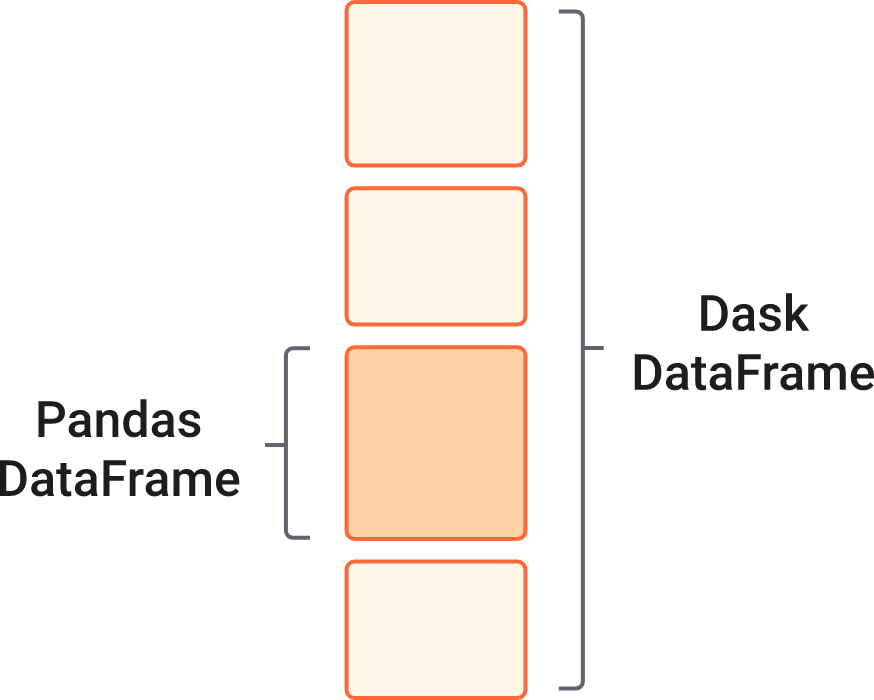

As you might guess from the `read_csv` function, most of the commonly used syntax and functionality of the Pandas API are preserved in Dask. The following code blocks should be familiar to you from your Pandas days (although they are gone now, because you will be switching to Dask in no time).

__Selecting columns and element-wise operations__

In [8]:
result = (
    dask_df["Numeric_0"] + dask_df["Numeric_9"] * dask_df["Numeric_3"]
)
result.compute().head()

0    1.301960
1    1.190679
2    1.100955
3    0.758272
4    0.926729
dtype: float64

__Conditional filtering__

In [9]:
dask_df[dask_df["Categorical_5"] == "A"].compute().head()

,Numeric_0,Numeric_1,Numeric_2,Numeric_3,Numeric_4,Numeric_5,Numeric_6,Numeric_7,Numeric_8,Numeric_9,Categorical_0,Categorical_1,Categorical_2,Categorical_3,Categorical_4,Categorical_5,Categorical_6,Categorical_7,Categorical_8,Categorical_9
1,0.814167,0.379423,0.196857,0.619969,0.595017,0.478217,0.150928,0.580445,0.292682,0.607309,I,B,J,Y,J,A,R,C,I,P
9,0.421256,0.700283,0.252628,0.676640,0.814156,0.416240,0.413232,0.460071,0.866812,0.730768,S,N,L,K,Q,A,B,W,O,D
16,0.282811,0.719339,0.207320,0.976588,0.949429,0.080404,0.990779,0.072801,0.482127,0.163088,I,O,Z,X,A,A,T,M,J,V
18,0.483087,0.841133,0.025510,0.009140,0.183722,0.325491,0.290477,0.706761,0.589473,0.117201,J,K,W,J,M,A,N,F,V,P
35,0.192446,0.274116,0.708766,0.960327,0.227727,0.432471,0.227079,0.811245,0.092382,0.857535,M,D,Z,M,C,A,Y,D,C,O


__Common summary statistics__

In [11]:
dask_df.describe().compute()

,Numeric_0,Numeric_1,Numeric_2,Numeric_3,Numeric_4,Numeric_5,Numeric_6,Numeric_7,Numeric_8,Numeric_9
count,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07,1.000000e+07
mean,5.000694e-01,4.999880e-01,4.999234e-01,5.001617e-01,4.999199e-01,5.000784e-01,4.999988e-01,4.998237e-01,4.999092e-01,5.000875e-01
std,2.886411e-01,2.885834e-01,2.886858e-01,2.887104e-01,2.886306e-01,2.886403e-01,2.886713e-01,2.887814e-01,2.886391e-01,2.887165e-01
min,1.564002e-07,9.838086e-10,1.560742e-07,2.491680e-07,8.348743e-08,6.555190e-08,4.902090e-08,6.893530e-08,7.024191e-09,2.179944e-07
25%,2.511082e-01,2.520286e-01,2.511258e-01,2.520083e-01,2.510887e-01,2.519130e-01,2.513019e-01,2.512131e-01,2.518856e-01,2.517978e-01
50%,5.017100e-01,5.021449e-01,5.024578e-01,5.020417e-01,5.012735e-01,5.023080e-01,5.013113e-01,5.017622e-01,5.019776e-01,5.023563e-01
75%,7.514503e-01,7.510077e-01,7.518552e-01,7.517292e-01,7.512685e-01,7.516721e-01,7.516851e-01,7.516377e-01,7.518002e-01,7.522887e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.999998e-01,9.999998e-01,1.000000e+00,9.999999e-01,1.000000e+00


In [14]:
dask_df["Categorical_3"].value_counts().compute().head()

Categorical_3
O    386038
C    385804
A    385493
P    385490
K    385116
Name: count, dtype: int64

__Groupby__

In [18]:
dask_df.groupby("Categorical_8")["Numeric_7"].mean().compute().head()

Categorical_8
A    0.498497
B    0.499767
C    0.500622
D    0.500307
E    0.499530
Name: Numeric_7, dtype: float64

Check out [this section of Dask user guide](https://docs.dask.org/en/stable/dataframe.html#scope) on the rest of the familiarities between Pandas and Dask.

### Lazy evaluation

Now, I want to draw your attention to the use of the `compute` function at the end of each code block.

Dask evaluates code blocks in lazy mode compared to Pandas' eager mode, which returns results immediately.

To draw a parallel in cooking, lazy evaluation is like preparing ingredients and chopping vegetables in advance, but only combining them to cook when needed. The `compute` function serves that purpose.

In contrast, eager evaluation is like throwing ingredients into the fire to cook as soon as they are ready. This approach ensures everything is ready to serve at once.

Lazy evaluation is key to Dask's excellent performance as it provides:

1. Reduced computation: Expressions are evaluated only when needed (when `compute` is called), avoiding unnecessary intermediate results that may not be used in the final result.

2. Optimal resource allocation: Lazy evaluation avoids allocating memory or processing power to intermediate results that may not be required.

3. Support for infinite or large datasets: Lazy evaluation processes data elements on-the-fly or in smaller chunks, enabling efficient utilization of memory resources.

and so on.

When the results of `compute` are returned, they are given as Pandas Series/DataFrames or NumPy arrays instead of native Dask DataFrames.

In [19]:
type(dask_df)

dask.dataframe.core.DataFrame

In [22]:
type(
    dask_df[["Numeric_5", "Numeric_6", "Numeric_7"]].mean().compute()
)

pandas.core.series.Series

The reason for this is that most data manipulation operations return only a subset of the original dataframe, taking up much smaller space. So, there won't be any need to use parallelism of Dask and continue the rest of your workflow either in Pandas or NumPy.

### Dask Bags and Dask Delayed for Unstructured Data

Dask Bags and Dask Delayed are two components of the Dask library that provide powerful tools for working with unstructured or semi-structured data and enabling lazy evaluation.

While in the past, tabular data was the most common, today's datasets often involve unstructured files such as images, text files, videos, and audio. Dask Bags provides the functionality and API to handle such unstructured files in a parallel and scalable manner.

For example, let's consider a simple illustration:


In [23]:
import dask.bag as db

# Create a Dask Bag from a list of strings
b = db.from_sequence(["apple", "banana", "orange", "grape", "kiwi"])

# Filter the strings that start with the letter 'a'
filtered_strings = b.filter(lambda x: x.startswith("a"))

# Map a function to convert each string to uppercase
uppercase_strings = filtered_strings.map(lambda x: x.upper())

# Compute the result as a list
result = uppercase_strings.compute()

print(result)

['APPLE']


In this example, we create a Dask Bag `b` from a list of strings. We then apply operations on the Bag to filter the strings that start with the letter 'a' and convert them to uppercase using the `filter()` and `map()` functions, respectively. Finally, we compute the result as a list using the `compute()` method and print the output.

Now imagine that you can perform the same operations on billions of strings stored in a text file. Without the lazy evaluation and parallelism offered by Dask Bags, you would face significant challenges. Read more about Bags [here](https://docs.dask.org/en/stable/bag.html).

As for Dask Delayed, it provides even more flexibility and introduces lazy evaluation and parallelism to various scenarios. With Dask Delayed, you can convert any native Python function into a lazy object using the @dask.delayed decorator.

Here is a simple example:

In [25]:
%%time

import time

import dask


@dask.delayed
def process_data(x):
    # Simulate some computation
    time.sleep(1)
    return x**2


# Generate a list of inputs
inputs = range(1000)

# Apply the delayed function to each input
results = [process_data(x) for x in inputs]

# Compute the results in parallel
computed_results = dask.compute(*results)

CPU times: user 234 ms, sys: 110 ms, total: 344 ms
Wall time: 42.1 s


In this example, we define a function `process_data` decorated with `@dask.delayed`. The function simulates some computational work by sleeping for 1 second and then returning the square of the input value.

Without parallelism, performing this computation on 1000 inputs would have taken more than 1000 seconds. However, with Dask Delayed and parallel execution, the computation only took about 42.1 seconds.

This example demonstrates the power of parallelism in reducing computation time by efficiently distributing the workload across multiple cores or workers. 

That's what parallelism is all about.

### Conclusion and Further Resources

Dask is one of the cornerstone libraries in the data ecosystem. It extends the functionality of most of the beloved libraries like NumPy, Pandas, and Spark, allowing seamless handling of larger-than-memory datasets. 

With Dask Bags and Dask delayed, it brings parallelism and lazy evaluation to untraditional scenarios like working with unstructured data or with native Python objects. 

If you are looking for a comprehensive resource on mastering Dask, check out the course offered by DataCamp - [Parallel Programming With Dask in Python](https://app.datacamp.com/learn/courses/parallel-programming-with-dask-in-python).

For more nitty-gritty details, be sure to give [the Dask docs](https://docs.dask.org/en/stable/) a thorough read. The official [Dask-recommended sources](https://docs.dask.org/en/stable/presentations.html#) are great as well.

Thank you for reading!